In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pysd
import pandas as pd
import scipy as sp

import os
import random

random.seed(111)
np.random.seed(111)

# A Collection of Non-Linear Stock and Flow Models

### Modeling the Biological Mechanisms That Determine the Dynamics of the Stress Response of the Human Body

Gizem Aktaş and Yaman Barlas 2018

I was able to simulate this model and perturb it with stochastic input, but since it was never published, it isn't well documented.

#### Stock and Flow  Graphic

![](https://metasd.com/wp-content/uploads/2018/09/stress_diag-1024x467.png)

Poster abstract [here.](https://proceedings.systemdynamics.org/2018/proceed/papers/P2360.pdf)

Download available [here](https://metasd.com/2018/09/biological-dynamics-stress-response/).

In [3]:
# Read in the model
stress_model = pysd.read_vensim("../../Data/StressResponseModel_converted-8/StressResponseModel_converted 8.mdl")
# Run the simulation
X = stress_model.run(params={"External Stress": 1}, final_time=10)
X.describe()

FileNotFoundError: [Errno 2] No such file or directory: '../../Data/StressResponseModel_converted-8/StressResponseModel_converted 8.mdl'

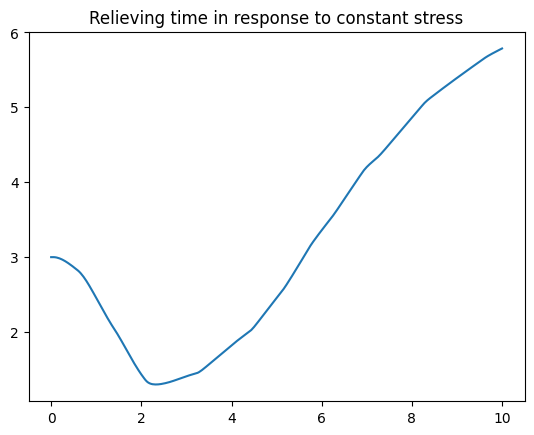

In [ ]:
plt.plot(X["Relieving Time"])
plt.title("Relieving time in response to constant stress")
plt.show()

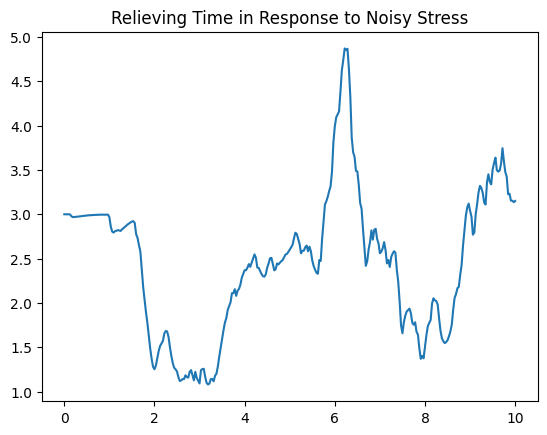

In [ ]:
noisy_extern_stress = lambda : 1 + 10 * np.random.randn()

stress_model.components.external_stress = noisy_extern_stress
X = stress_model.run(final_time=10)
plt.plot(X["Relieving Time"])
plt.title("Relieving Time in Response to Noisy Stress")
plt.show()

### Financial Instability

Available [here](https://exchange.iseesystems.com/models/player/crelis/financial-instability).

In [4]:
financial_model = pysd.read_xmile("../../Data/FinancialInstabilityModel/Financial-instability.stmx")

/Users/djpassey/Code/graphinference/graphinf_venv/lib/python3.9/site-packages/pysd/builders/python/python_expressions_builder.py:462: UserWarning: 

Trying to translate 'HISTORY' which it is not implemented on PySD. The translated model will crash... 
  warnings.warn(


In [5]:
stress_model.state

NameError: name 'stress_model' is not defined

In [15]:

class EconomicGrowthRate:
    """Economic growth rate in the finanial instability model.

    Stores historical production values in order to implement
    a delay. Pysd does not implement Stella's HISTROY function.
    """
    def __init__(self):
        self.time = []
        self.production_history = []
        self.delay = 1.0

    def __call__(self):

        # Check if the simulation was restarted
        current_time = financial_model.components.time()
        initial_time = financial_model.components.initial_time()
        time_step = financial_model.components.time_step()
        if (current_time - initial_time) < time_step:
            # Reset history if the simulation was restarted
            self.time = []
            self.production_history = []

        # Retrieve and store time and production
        self.time.append(current_time)
        curr_production = financial_model.components.production()
        self.production_history.append(curr_production)

        # In the case that there is not enough history return zero
        if current_time < self.delay:
            return 0.0

        # Interpolate past production
        prev_production_func = sp.interpolate.interp1d(
            self.time,
            self.production_history
        )
        # Retrieve past production
        prev_production = prev_production_func(current_time - self.delay)
        # Return (p[t] - p[t-1]) / p[t-1]
        return financial_model.components.zidz(curr_production - prev_production, prev_production)


        

In [19]:
financial_model.components.economic_growth_rate = EconomicGrowthRate()

In [45]:

X.describe()

,capital,economic growth rate,employment rate,profits,wage share
count,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000
mean,434.570307,0.002814,0.801437,1.251584,0.992753
std,26.146424,0.028945,0.029978,1.863729,0.003861
min,381.547483,-0.043433,0.753027,-1.831162,0.984916
25%,416.357657,-0.025782,0.771629,-0.573223,0.989444
50%,433.402143,0.002709,0.800058,1.279192,0.992740
75%,451.884751,0.031499,0.831245,3.074142,0.996340
max,498.467936,0.049455,0.850354,4.520470,1.000000


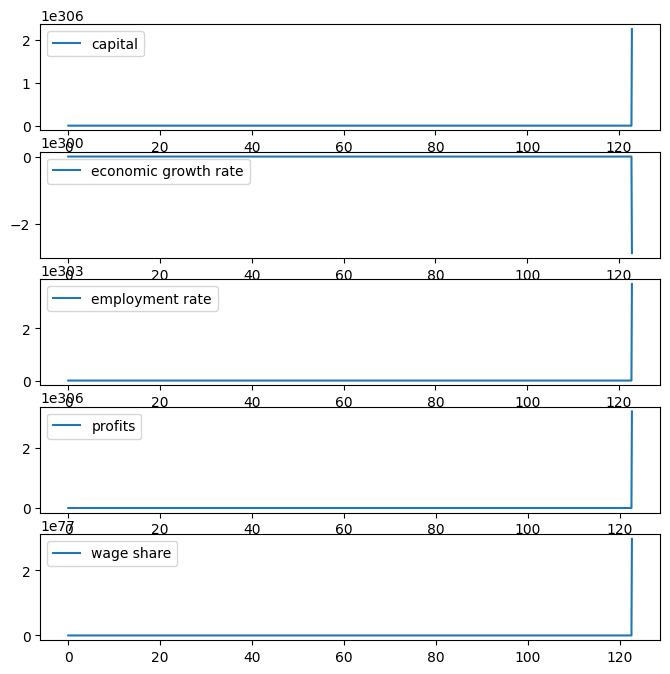

In [54]:
econ_indicators = ["capital", "economic growth rate", "employment rate", "profits", "wage share"]
X = financial_model.run(
    final_time=800,
    return_columns=econ_indicators,
    initial_condition=(0, {"capital": 200})
)


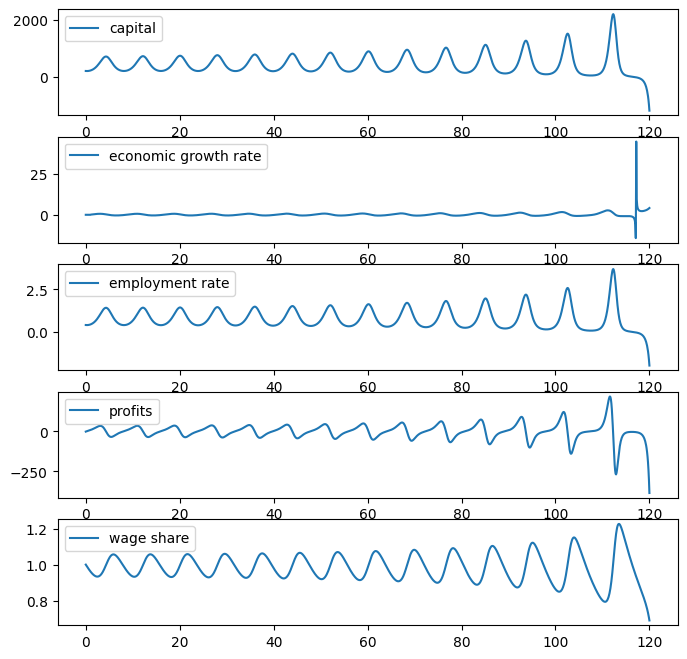

In [60]:

fig, ax = plt.subplots(5, 1, figsize=(8,8))
for i, ei in enumerate(econ_indicators):
    ax[i].plot(X[ei][:120], label=ei)
    ax[i].legend()


plt.show()

[Opiod use model](https://jamanetwork.com/journals/jamanetworkopen/fullarticle/2723405)

[MetaSD Model library](https://metasd.com/model-library/)